<FONT size="5.9pt"> **NB2 - PROSPECTIVE CONSEQUENTIAL LCA OF BARK BIOREFINING - PART 1**
</FONT> 

This Jupyter Notebook was used to conduct an environmental prospective consequential LCA study comparing bark combustion and biorefinery processes (see manuscript). The [*lca_algebraic*](https://link.springer.com/article/10.1007/s11367-021-01993-z) library was used to build the parameterised LCA model; refer to its [documentation](https://github.com/oie-mines-paristech/lca_algebraic/tree/master) for details. Time-differenciated climate impacts were calculated using dynamic characterisation factors (DCFs) from Levasseur et al. (2010) over a 100-year time horizon, based on the ALIGNED guidelines [(Hamelin et al., 2024)](https://zenodo.org/records/10843259). Other impact categories from the IPCC2021 and ReCiPe 2016 LCIA methods were also included.

Part 1 builds a parameterised model to perform the LCA study using the IPCC 2021 and ReCiPe 2016 LCIA methods. The time-differentiated climate impacts are calculated in Part 2. 

# 1. Set-up the directories <a class="anchor" id="section1"></a> 

It is advised to create a new folder in which the Jupyter Notebooks are downloaded from the GitHub repository and saved. A "results" folder will be created to store all outputs of the code (e.g., graphs, tables). This code uploads the ecoinvent database from a local directory. Therefore, a license for the ecoinvent is required and the database should be stored on your computer directly.

In [1]:
import os
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# define the initial working directory
wdir = Path().resolve() # get the directory of the notebook
pdir = os.path.join(wdir,'projects')
print(f"Working Directory: {wdir}")

# set the BW project directory
pathlib.Path(pdir).mkdir(parents=True, exist_ok=True)
os.environ['BRIGHTWAY2_DIR'] = pdir
print('Project directory:', os.environ['BRIGHTWAY2_DIR'])

# set the directory to store the results
result_dir = os.path.join(wdir,'results')   
pathlib.Path(result_dir).mkdir(parents=True, exist_ok=True)
print('Results directory:', result_dir)

# set the directory in which the databases are stored
db_dir = os.path.join(wdir,'databases')
pathlib.Path(db_dir).mkdir(parents=True, exist_ok=True)
print('Databases directory:', db_dir)

Working Directory: /home/leabraud/Documents/LCAbark
Project directory: /home/leabraud/Documents/LCAbark/projects
Results directory: /home/leabraud/Documents/LCAbark/results
Databases directory: /home/leabraud/Documents/LCAbark/databases


# 2. Import background databases <a class="anchor" id="section2"></a>

The background databases used in this study correspond to ecoinvent 3.9 consequential and biosphere3. Several versions of the ecoinvent database were generated using the [*premise*](https://www.sciencedirect.com/science/article/pii/S136403212200226X) Python library (see jupyter notebook NB1). 

In [3]:
import lca_algebraic as alg
import brightway2 as bw

# initiate the project / choose project name
alg.initProject('lca_bark') ### NAME OF THE PROJECT CAN BE CHANGED

# import the ecoinvent database from a local directory
alg.importDb("ecoinvent_3.9_conseq", str(db_dir + '/ecoinvent 3.9_consequential_ecoSpold02/datasets')) ## VERSION OF ECOINVENT & DIRECTORY TO BE CHANGED

# overview of the databases
alg.list_databases()

Using environment variable BRIGHTWAY2_DIR for data directory:
/home/leabraud/Documents/LCAbark/projects


/tmp/ipykernel_43176/2457968347.py:5: DeprecationWarning: DEPRECATED : Use bw2io.import_ecoinvent_release() instead
  alg.initProject('lca_bark') ### NAME OF THE PROJECT CAN BE CHANGED
/tmp/ipykernel_43176/2457968347.py:8: DeprecationWarning: DEPRECATED : Use the new bw2io.import_ecoinvent_release instead
  alg.importDb("ecoinvent_3.9_conseq", str(db_dir + '/ecoinvent 3.9_consequential_ecoSpold02/datasets')) ## VERSION OF ECOINVENT & DIRECTORY TO BE CHANGED
[WARNING] Database 'ecoinvent_3.9_conseq' has already been imported 


Biosphere database already present!!! No setup is needed


,backend,nb_activities,type
name,,,
biosphere3,sqlite,4709,biosphere
ecoinvent_3.9_conseq,sqlite,18856,background
ecoinvent_consequential_3.9_remind_SSP2-PkBudg500_2045,sqlite,22517,background
ecoinvent_consequential_3.9_remind_SSP2-Base_2045,sqlite,22517,background
ecoinvent_consequential_3.9_remind_SSP1-PkBudg500_2045,sqlite,22517,background
ecoinvent_consequential_3.9_image_SSP2-Base_2045,sqlite,25105,background
indirect_GHGs_ei39REMIND,sqlite,26,background
indirect_GHGs_ei39,sqlite,26,background
Foreground DB REMIND,sqlite,40,background


# 3. Create foreground databases <a class="anchor" id="section3"></a>

In [4]:
USER_DB = 'Foreground DB' ## NAME OF THE FOREGROUND DATABASE CAN BE CHANGED
alg.resetDb(USER_DB)
alg.resetParams()

[WARNING] Db Foreground DB was here. Reseting it


## 3.1. Get ecoinvent datasets

In [5]:
# Choose which version of ecoinvent to perform the LCA calculations with
ei = 'ecoinvent_3.9_conseq'
#ei = 'ecoinvent_consequential_3.9_remind_SSP2-PkBudg500_2045'
#ei = 'ecoinvent_consequential_3.9_remind_SSP2-Base_2045'
#ei = 'ecoinvent_consequential_3.9_remind_SSP1-PkBudg500_2045'
#ei = 'ecoinvent_consequential_3.9_image_SSP2-Base_2045'

In [6]:
# technopshere flows
grid_SE = alg.findActivity(name='market for electricity, high voltage', loc = 'SE', db_name=ei) 
grid_RER = alg.findActivity(name='market group for electricity, high voltage', loc = 'RER', db_name=ei) 
ethylacetate = alg.findActivity(name='ethyl acetate production', loc = 'RER', db_name=ei) 
CO2 = alg.findActivity(name='carbon dioxide production, liquid', loc = 'RER', db_name=ei)
sodiumbicarbonate = alg.findActivity(name='market for sodium bicarbonate', loc = 'GLO', db_name=ei)
sodiumhydroxide = alg.findActivity(name='market for sodium hydroxide, without water, in 50% solution state', loc = 'GLO', db_name=ei)
quicklime = alg.findActivity(name='quicklime production, milled, loose', loc = 'CH', db_name=ei)
wwt = alg.findActivity(name='treatment of wastewater, average, wastewater treatment', loc = 'Europe without Switzerland', db_name=ei)
mw_RER = alg.findActivity(name='market group for municipal solid waste', loc = 'RER', db_name=ei) 
heatwoodchips = alg.findActivity(name='heat production, wood chips from industry, at furnace 50kW', loc = 'CH', db_name=ei)

# substituted products
talloil = alg.findActivity(name='tall oil refinery operation', loc = 'GLO', db_name=ei) 
potatostarch = alg.findActivity(name='potato starch production', loc = 'DE', db_name=ei) 
phenol = alg.findActivity(name='phenol production, from cumene', loc = 'RER', db_name=ei)
pulp = alg.findActivity(name='sulfate pulp production, from softwood, unbleached', loc = 'RER', db_name=ei)
limestone = alg.findActivity(name='market for limestone residue', loc = 'CH', db_name=ei)

# biosphere flows
ethylacetateemission = alg.findActivity(name='Ethyl acetate', db_name='biosphere3', categories = ('air',))
water = alg.findActivity(name='Water, river', db_name='biosphere3', categories = ('natural resource','in water'))
carbondioxide = alg.findActivity(name='Carbon dioxide, fossil', db_name='biosphere3', categories = ('air',))
carbondioxidenonfossil = alg.findActivity(name='Carbon dioxide, non-fossil', db_name='biosphere3', categories = ('air',))

## 3.2. Modify the ecoinvent dataset for heat production via cogeneration

The ecoinvent dataset for heat production from wood chips was used to model the environmental burdens of marginal heat supply in both biorefinery configurations. It was also used to calculate the impacts of bark combustion in the combustion scenario and residual biomass combustion in the biorefineries. The dataset was adapted for each specific application (see below).

In [7]:
# dataset selected in ecoinvent
heat = alg.findActivity(name='heat and power co-generation, wood chips, 6667 kW, state-of-the-art 2014', loc = 'SE', db_name=ei)

### 3.2.1. Combustion of bark 

The new dataset "heat_CHP_bark" includes only the impacts associated with the cogeneration process itself, excluding those from wood chip production (assumed similr as bark) and direct non-fossil emissions from wood combustion. The system boundaries exclude bark production (as this process is similar in all three assessed scenarios), while biogenic carbon emissions are accounted for separately. Since the properties of wood chips and bark are similar, it was assumed that combustion processes would result in the same impacts regardless of whether wood chips or bark are used as input.

In [8]:
heat_CHP_bark = alg.copyActivity(USER_DB, heat, code = 'heat and power co-generation, wood chips, 6667 kW, state-of-the-art 2014', withExchanges=True)
heat_CHP_bark.deleteExchanges('Carbon dioxide, non-fossil')
heat_CHP_bark.deleteExchanges('Carbon monoxide, non-fossil')
if ei == 'ecoinvent_3.9_conseq':
    heat_CHP_bark.deleteExchanges('wood chips, wet, measured as dry mass') # for ecoinvent 3.9
else:    
    heat_CHP_bark.deleteExchanges('market for wood chips, wet, measured as dry mass')
#alg.printAct(heat_CHP_bark)

### 3.2.2. Burdens from marginal heat production

The unmodified ecoinvent dataset was used as a basis. Here, the objective is to model the heat production from wood chips that would be required to compensate for the heat produced when bark is combusted in the business-as-usual scenario (i.e. combustion scenario). The total amount of heat that would need to be produced for compensation corresponds to the total amount of heat resulting from the combustion of 1 kg DW-eq of bark minus the heat produced via combustion of the residual biomass obtained in the biorefinery. The original process extracted from ecoinvent is not changed since the impacts from wood chips production and combustion are accounted for. The biogenic CO2 and CO from the cogeneration process are not removed. The original activity is simply copied and given a new name for distinction.

In [9]:
heat_CHP_woodchips = alg.copyActivity(USER_DB, heat, code = 'heat and power co-generation, wood chips, 6667 kW, state-of-the-art 2014', withExchanges=True)

[WARNING] Activity 'heat and power co-generation, wood chips, 6667 kW, state-of-the-art 2014' was already in 'Foreground DB'. Overwriting it


### 3.2.3. Heat production from residual biomass

Again, the same ecoinvent dataset is used as a basis. The amount of residual biomass produced at each processing step is calculated from the mass and carbon balance. The amount of heat produced is calculated using the relation: 1 kg dry mass => 8.5 MJ according to the ecoinvent dataset for heat from cogeneration using wood chips. The same dataset as the one used for heat production from bark is used. No impacts from the biomass and no direct emissions are accounted for. A new name is given for distinction. 

In [10]:
heat_CHP_RB = alg.copyActivity(USER_DB, heat, code = 'heat and power co-generation, wood chips, 6667 kW, state-of-the-art 2014', withExchanges=True)
heat_CHP_RB.deleteExchanges('Carbon dioxide, non-fossil')
heat_CHP_RB.deleteExchanges('Carbon monoxide, non-fossil')
if ei == 'ecoinvent_3.9_conseq':
    heat_CHP_RB.deleteExchanges('wood chips, wet, measured as dry mass') # ecoinvent 3.9
else:
    heat_CHP_RB.deleteExchanges('market for wood chips, wet, measured as dry mass')

[WARNING] Activity 'heat and power co-generation, wood chips, 6667 kW, state-of-the-art 2014' was already in 'Foreground DB'. Overwriting it


In [11]:
# check the climae impacts of heat production using IPCC 2021
ipcc2021 = alg.findMethods('global warming potential (GWP100)', 'IPCC 2021')[0]
climate_impacts_heat_CHP_RB = alg.compute_impacts([heat_CHP_RB],[ipcc2021])
climate_impacts_heat_CHP_RB

[INFO] Db changed recently, clearing cache expr
[INFO] Db changed recently, clearing cache lcia


,climate change - global warming potential (GWP100)[kg CO2-Eq]
"heat and power co-generation, wood chips, 6667 kW, state-of-the-art 2014[SE]",-0.0142485


# 4. Create foreground parameters <a class="anchor" id="section4"></a>

## 4.1. Evaluate the influence of the geographical location

In the sensititvity analysis, the influence of the geographical location on the LCA results is analysed. There are no European market for heat production from cogeneration in the consequential ecoinvent v.3.9 database. However, the dataset exists for many locations. The only differences between the datasets are the electricity mix and the municipal solid waste treatment. Here, both the electricity mix and the waste treatment processes are changed based on the geographical location. List of countries analysed in the sensitivity analysis: SE, NO, FI, DK, FR, DE, BE, LU, NL, AT.

In [12]:
# SE and RER have already been created above
grid_NO = alg.findActivity(name='market for electricity, high voltage', loc = 'NO', db_name=ei) 
grid_FI = alg.findActivity(name='market for electricity, high voltage', loc = 'FI', db_name=ei) 
grid_DK = alg.findActivity(name='market for electricity, high voltage', loc = 'DK', db_name=ei) 
grid_FR = alg.findActivity(name='market for electricity, high voltage', loc = 'FR', db_name=ei) 
grid_DE = alg.findActivity(name='market for electricity, high voltage', loc = 'DE', db_name=ei) 
grid_BE = alg.findActivity(name='market for electricity, high voltage', loc = 'BE', db_name=ei) 
grid_LU = alg.findActivity(name='market for electricity, high voltage', loc = 'LU', db_name=ei) 
grid_NL = alg.findActivity(name='market for electricity, high voltage', loc = 'NL', db_name=ei) 
grid_AT = alg.findActivity(name='market for electricity, high voltage', loc = 'AT', db_name=ei) 

# RER has already been created above
mw_SE = alg.findActivity(name='market for municipal solid waste', loc = 'SE', db_name=ei) 
mw_NO = alg.findActivity(name='market for municipal solid waste', loc = 'NO', db_name=ei) 
mw_FI = alg.findActivity(name='market for municipal solid waste', loc = 'FI', db_name=ei) 
mw_DK = alg.findActivity(name='market for municipal solid waste', loc = 'DK', db_name=ei) 
mw_FR = alg.findActivity(name='market for municipal solid waste', loc = 'FR', db_name=ei) 
mw_DE = alg.findActivity(name='market for municipal solid waste', loc = 'DE', db_name=ei) 
mw_BE = alg.findActivity(name='market for municipal solid waste', loc = 'BE', db_name=ei) 
mw_LU = alg.findActivity(name='market for municipal solid waste', loc = 'LU', db_name=ei) 
mw_NL = alg.findActivity(name='market for municipal solid waste', loc = 'NL', db_name=ei) 
mw_AT = alg.findActivity(name='market for municipal solid waste', loc = 'AT', db_name=ei) 

In [13]:
# create switch parameter for electricity mix - default value is SE
grid_loc = alg.newEnumParam(
    name = 'grid_loc',
    values = ['grid_SE','grid_NO','grid_FI','grid_DK','grid_FR','grid_DE','grid_BE','grid_LU','grid_NL','grid_AT','grid_RER'],
    default = 'grid_SE',
    #label = 'source of electricity - biorefinery',
    description = "Switch on the source of electricty used in the biorefinery",
    group = 'energy')

# create the virtual activity corresponding to the switch
grid_switch_act = alg.newSwitchAct(dbname = USER_DB,
                                   name = 'grid_switch_act',
                                   paramDef = grid_loc,
                                   acts_dict = {'grid_SE' : grid_SE,
                                                'grid_NO': grid_NO,
                                                'grid_FI': grid_FI,
                                                'grid_DK': grid_DK,
                                                'grid_FR': grid_FR,
                                                'grid_DE': grid_DE,
                                                'grid_BE': grid_BE,
                                                'grid_LU': grid_LU,
                                                'grid_NL': grid_NL,
                                                'grid_AT': grid_AT,
                                                'grid_RER': grid_RER})

In [14]:
# create switch parameter for municipal solid waste treatment - default value is RER
mw_loc = alg.newEnumParam(
    name = 'mw_loc',
    values = ['mw_SE','mw_NO','mw_FI','mw_DK','mw_FR','mw_DE','mw_BE','mw_LU','mw_NL','mw_AT','mw_RER'],
    default = 'mw_RER',
    #label = 'source of electricity - biorefinery',
    description = "Switch on the source of electricty used in the biorefinery",
    group = 'waste')

# create the virtual activity corresponding to the switch
mw_switch_act = alg.newSwitchAct(dbname = USER_DB,
                                   name = 'mw_switch_act',
                                   paramDef = mw_loc,
                                   acts_dict = {'mw_SE': mw_SE,
                                                'mw_NO': mw_NO,
                                                'mw_FI': mw_FI,
                                                'mw_DK': mw_DK,
                                                'mw_FR': mw_FR,
                                                'mw_DE': mw_DE,
                                                'mw_BE': mw_BE,
                                                'mw_LU': mw_LU,
                                                
                                                'mw_NL': mw_NL,
                                                'mw_AT': mw_AT,
                                                'mw_RER': mw_RER})

## 4.2. Evaluate the influence of the percentage of losses 

The float parameter defined corresponds to the percentage of biomass losses in the biorefinery processes. An increase in the percentage of losses means that less of the (co)products are produced but more heat is generated from the combustion of residual biomass. The percentage of losses varies between 0 and 30%. 

In [15]:
percentage_losses = alg.newFloatParam(name = "percentage_losses",
                           default = 0, min = 0, max = 1, 
                           unit = '%',
                           group = 'biomass')

## 4.3. Evaluate the influence of the integration of the biorefinery with co-located source of energy

The boolean parameter defined changes the amount of electricity used in the biorefinery processes. In the integrated biorefinery (standalone = 0), no external electricity is required and all the energy is supplied from the co-located source which comes into the system free of burdens. In the standalone biorefinery (standalone = 1), the electricity required is supplied by the grid. 

In [16]:
standalone = alg.newBoolParam('standalone', 
                               default = 1, # 1 means the biorefinery system is stand-alone, 0 it is integrated
                               group = 'booleans')

# 5. Add the parameters to the foreground activities <a class="anchor" id="section5"></a>

## 5.1. Create parameterised heat production processes

The amount of electricity and municipal solid wastes are not changed, only the geographical location of the datasets. 

In [17]:
heat_CHP_bark.updateExchanges({'electricity*':grid_switch_act})
heat_CHP_bark.updateExchanges({'municipal*':mw_switch_act})

heat_CHP_woodchips.updateExchanges({'electricity*':grid_switch_act})
heat_CHP_woodchips.updateExchanges({'municipal*':mw_switch_act})

heat_CHP_RB.updateExchanges({'electricity*':grid_switch_act})
heat_CHP_RB.updateExchanges({'municipal*':mw_switch_act})

## 5.2. Create parameterised biorefinery processes

All the activities are scaled to the functional unit i.e. the processing of 1 kg of bark dry mass. 

In [18]:
# lipophilic extraction from bark
lipophilic_extraction = alg.newActivity(db_name = USER_DB, 
         name = 'lipophilic extraction',
         unit = 'unit',
         exchanges={
             # technosphere inputs
             ethylacetate: 0.002,
             grid_SE: 2.44*standalone,
             # emissions
             ethylacetateemission: 0.002
         })

lipophilic_extraction.updateExchanges({'electricity*':grid_switch_act})
alg.printAct(lipophilic_extraction).to_excel(str(result_dir+'/lipophilic_extraction_'+ei+'.xlsx'))
alg.printAct(lipophilic_extraction)

lipophilic extraction (1.000000 unit)  \
                                                                     input   
Ethyl acetate                                                Ethyl acetate   
ethyl acetate production                     ethyl acetate production[RER]   
market for electricity, high voltage                   grid_switch_act{FG}   

                                                                      
                                               amount           unit  
Ethyl acetate                                   0.002       kilogram  
ethyl acetate production                        0.002       kilogram  
market for electricity, high voltage  2.44*standalone  kilowatt hour

In [19]:
# sugar extraction from lipophilic depleted bark
sugar_extraction = alg.newActivity(db_name = USER_DB, 
 name = 'sugar extraction',
 unit = 'unit',
 exchanges={
     grid_SE: 5*standalone,
     wwt: -0.00007,
     # natural resources
     water: 0.00007
 })

sugar_extraction.updateExchanges({'electricity*':grid_switch_act})
alg.printAct(sugar_extraction).to_excel(str(result_dir+'/sugar_extraction_'+ei+'.xlsx'))
alg.printAct(sugar_extraction)

sugar extraction (1.000000 unit)  \
                                                                                                input   
Water, river                                                                             Water, river   
market for electricity, high voltage                                              grid_switch_act{FG}   
treatment of wastewater, average, wastewater tr...  treatment of wastewater, average, wastewater t...   

                                                                  \
                                                          amount   
Water, river                                               7e-05   
market for electricity, high voltage                5*standalone   
treatment of wastewater, average, wastewater tr...        -7e-05   

                                                                   
                                                             unit  
Water, river                                          cubic meter  
market for electricity, high voltage                kilowatt hour  
treatment of wastewater, average, wastewater tr...    cubic meter

In [20]:
sugar_extraction_withlosses = alg.newActivity(db_name = USER_DB,
                                     name = 'sugar_extraction_withlosses',
                                     unit = 'unit',
                                     exchanges={sugar_extraction:1 # - percentage_losses
                                    })

In [21]:
# pulping of sugar depleted bark
pulping = alg.newActivity(db_name = USER_DB, 
 name = 'pulping',
 unit = 'unit',
 exchanges={
     sodiumhydroxide: 0.00523,
     quicklime: 0.00629, # calcium oxide
     wwt: -0.00035,
     grid_SE: 1.03*standalone,
     heatwoodchips:0.35,
     CO2: 0.124*standalone,
     limestone:-0.00551,
     # natural resources
     water: 0.00035
 })

pulping.updateExchanges({'electricity*':grid_switch_act})
alg.printAct(pulping).to_excel(str(result_dir+'/pulping_'+ei+'.xlsx'))
alg.printAct(pulping)

pulping (1.000000 unit)  \
                                                                                                input   
Water, river                                                                             Water, river   
carbon dioxide production, liquid                              carbon dioxide production, liquid[RER]   
heat production, wood chips from industry, at f...  heat production, wood chips from industry, at ...   
market for electricity, high voltage                                              grid_switch_act{FG}   
market for limestone residue                                         market for limestone residue[CH]   
market for sodium hydroxide, without water, in ...  market for sodium hydroxide, without water, in...   
quicklime production, milled, loose                           quicklime production, milled, loose[CH]   
treatment of wastewater, average, wastewater tr...  treatment of wastewater, average, wastewater t...   

                                                                      \
                                                              amount   
Water, river                                                 0.00035   
carbon dioxide production, liquid                   0.124*standalone   
heat production, wood chips from industry, at f...              0.35   
market for electricity, high voltage                 1.03*standalone   
market for limestone residue                                -0.00551   
market for sodium hydroxide, without water, in ...           0.00523   
quicklime production, milled, loose                          0.00629   
treatment of wastewater, average, wastewater tr...          -0.00035   

                                                                   
                                                             unit  
Water, river                                          cubic meter  
carbon dioxide production, liquid                        kilogram  
heat production, wood chips from industry, at f...      megajoule  
market for electricity, high voltage                kilowatt hour  
market for limestone residue                             kilogram  
market for sodium hydroxide, without water, in ...       kilogram  
quicklime production, milled, loose                      kilogram  
treatment of wastewater, average, wastewater tr...    cubic meter

In [22]:
pulping_withlosses = alg.newActivity(db_name = USER_DB,
                                     name = 'pulping_withlosses',
                                     unit = 'unit',
                                     exchanges={pulping:1 #- percentage_losses
                                               })

In [23]:
# production of heat from residual biomass via cogeneration
heat_residues = alg.newActivity(db_name = USER_DB, 
 name = 'heat (RB)',
 unit = 'unit',
 exchanges={
     heat_CHP_RB: 1.53*(1+percentage_losses)
 })
alg.printAct(heat_residues)

heat (RB) (1.000000 unit)  \
                                                                                                input   
heat and power co-generation, wood chips, 6667 ...  heat and power co-generation, wood chips, 6667...   

                                                                                   \
                                                                           amount   
heat and power co-generation, wood chips, 6667 ...  1.53*percentage_losses + 1.53   

                                                               
                                                         unit  
heat and power co-generation, wood chips, 6667 ...  megajoule

In [24]:
# conversion of lipophilic extractives into tall oil (no impacts assumed)
processA = alg.newActivity(db_name = USER_DB, 
 name = 'process A',
 unit = 'unit',
 exchanges={
 })

In [25]:
# conversion of sugar extractives into starch (no impacts assumed)
processB = alg.newActivity(db_name = USER_DB, 
 name = 'process B',
 unit = 'unit',
 exchanges={
 })

In [26]:
# conversion of lignin into phenol (no impacts assumed)
processC = alg.newActivity(db_name = USER_DB, 
 name = 'process C',
 unit = 'unit',
 exchanges={
 })

## 5.3. Create parameterised end-of-life processes

The end-of-life (EoL) processes were differentiated for each product and application since the lifespan of the products varies (and will therefore influence the calculation of the climate impacts using dynamic chatacterisation factors). All products are considered to be solid wastes treated by incineration at their EoL. The amount of waste treated depends on the percentage of biomass losses in the biorefinery processes. More losses means that less products are generated and therefore less wastes are treated. 

| Product            | Application          | Share   | Lifespan       | Amount   | Unit |
|--------------------|----------------------|---------|----------------|----------|------|
| Pulp               | Biomedical products | 33.33%  | <1 year        | 0.1367   | kg   |
| Pulp               | Textiles            | 33.33%  | 5 years        | 0.1367   | kg   |
| Pulp               | Nanocomposites      | 33.33%  | 20 years       | 0.1367   | kg   |
| Phenol             | Automotive          | 40%     | 13 years       | 0.068    | kg   |
| Phenol             | Construction        | 23%     | 50 years       | 0.0391   | kg   |
| Phenol             | Furniture           | 18%     | 15 years       | 0.0306   | kg   |
| Phenol             | Electronics         | 14%     | 7 years        | 0.0238   | kg   |
| Phenol             | Others              | 5%      | 21.25 years    | 0.0085   | kg   |
| Starch             | Cardboard boxes     | 100%    | 1 year         | 0.22     | kg   |
| Tall oil           | Biofuel             | 100%    | <1 year        | 0.02     | kg   |
| Residual biomass   | Heat production     | 100%    | <1 year        | 1.52915  | MJ   |


In [27]:
# treatment of the biorefinery products at their EoL (aggregated value)
# amount corresponds to the mass of the biorefinery products excluding the residues (which are combusted for heat production)
EoL = alg.newActivity(db_name = USER_DB, 
 name = 'EoL',
 unit = 'unit',
 exchanges={
     #mw_RER: -(0.82*(1-percentage_losses))
     mw_RER: -(1-0.18*(1+percentage_losses))
 })
EoL.updateExchanges({'municipal*':mw_switch_act})
alg.printAct(EoL).to_excel(str(result_dir+'/EoL_'+ei+'.xlsx'))
alg.printAct(EoL)

EoL (1.000000 unit)  \
                                                     input   
market group for municipal solid waste   mw_switch_act{FG}   

                                                                       \
                                                               amount   
market group for municipal solid waste  0.18*percentage_losses - 0.82   

                                                  
                                            unit  
market group for municipal solid waste  kilogram

In [28]:
# treatment of the pulp for biomedical application
EoL_pulp_biomed = alg.newActivity(db_name = USER_DB,
                                  name = 'EoL_pulp_biomed',
                                  unit = 'unit',
                                  exchanges={
                                      #mw_RER: -(0.3333*0.41*(1-percentage_losses))
                                      mw_RER: -(0.3333*(0.41/0.82)*(1-0.18*(1+percentage_losses)))
                                  })
EoL_pulp_biomed.updateExchanges({'municipal*':mw_switch_act})
alg.printAct(EoL_pulp_biomed).to_excel(str(result_dir+'/EoL_pulp_biomed_'+ei+'.xlsx'))
alg.printAct(EoL_pulp_biomed)

EoL_pulp_biomed (1.000000 unit)  \
                                                                 input   
market group for municipal solid waste               mw_switch_act{FG}   

                                                                               \
                                                                       amount   
market group for municipal solid waste  0.029997*percentage_losses - 0.136653   

                                                  
                                            unit  
market group for municipal solid waste  kilogram

In [29]:
# treatment of the pulp for textile application
EoL_pulp_textile = alg.newActivity(db_name = USER_DB,
                                  name = 'EoL_pulp_textile',
                                  unit = 'unit',
                                  exchanges={
                                      #mw_RER: -(0.3333*0.41*(1-percentage_losses))
                                      mw_RER: -(0.3333*(0.41/0.82)*(1-0.18*(1+percentage_losses)))
                                  })
EoL_pulp_textile.updateExchanges({'municipal*':mw_switch_act})
alg.printAct(EoL_pulp_textile).to_excel(str(result_dir+'/EoL_pulp_textile_'+ei+'.xlsx'))
alg.printAct(EoL_pulp_textile)

EoL_pulp_textile (1.000000 unit)  \
                                                                  input   
market group for municipal solid waste                mw_switch_act{FG}   

                                                                               \
                                                                       amount   
market group for municipal solid waste  0.029997*percentage_losses - 0.136653   

                                                  
                                            unit  
market group for municipal solid waste  kilogram

In [30]:
# treatment of the pulp for nanocomposite application
EoL_pulp_nanocomposite = alg.newActivity(db_name = USER_DB,
                                  name = 'EoL_pulp_nanocomposite',
                                  unit = 'unit',
                                  exchanges={
                                      #mw_RER: -(0.3333*0.41*(1-percentage_losses))
                                      mw_RER: -(0.3333*(0.41/0.82)*(1-0.18*(1+percentage_losses)))
                                  })
EoL_pulp_nanocomposite.updateExchanges({'municipal*':mw_switch_act})
alg.printAct(EoL_pulp_nanocomposite).to_excel(str(result_dir+'/EoL_pulp_nanocomposite_'+ei+'.xlsx'))
alg.printAct(EoL_pulp_nanocomposite)

EoL_pulp_nanocomposite (1.000000 unit)  \
                                                                        input   
market group for municipal solid waste                      mw_switch_act{FG}   

                                                                               \
                                                                       amount   
market group for municipal solid waste  0.029997*percentage_losses - 0.136653   

                                                  
                                            unit  
market group for municipal solid waste  kilogram

In [31]:
# treatment of the phenol for automotive application
EoL_phenol_auto = alg.newActivity(db_name = USER_DB,
                                  name = 'EoL_phenol_auto',
                                  unit = 'unit',
                                  exchanges={
                                      #mw_RER: -(0.4*0.17*(1-percentage_losses))
                                      mw_RER: -(0.4*(0.17/0.82)*(1-0.18*(1+percentage_losses)))
                                  })
EoL_phenol_auto.updateExchanges({'municipal*':mw_switch_act})
alg.printAct(EoL_phenol_auto).to_excel(str(result_dir+'/EoL_phenol_auto_'+ei+'.xlsx'))
alg.printAct(EoL_phenol_auto)

EoL_phenol_auto (1.000000 unit)  \
                                                                 input   
market group for municipal solid waste               mw_switch_act{FG}   

                                                                                      \
                                                                              amount   
market group for municipal solid waste  0.0149268292682927*percentage_losses - 0.068   

                                                  
                                            unit  
market group for municipal solid waste  kilogram

In [32]:
# treatment of the phenol for construction application
EoL_phenol_construction = alg.newActivity(db_name = USER_DB,
                                  name = 'EoL_phenol_construction',
                                  unit = 'unit',
                                  exchanges={
                                      #mw_RER: -(0.23*0.17*(1-percentage_losses))
                                      mw_RER: -(0.23*(0.17/0.82)*(1-0.18*(1+percentage_losses)))
                                  })
EoL_phenol_construction.updateExchanges({'municipal*':mw_switch_act})
alg.printAct(EoL_phenol_construction).to_excel(str(result_dir+'/EoL_phenol_construction_'+ei+'.xlsx'))
alg.printAct(EoL_phenol_construction)

EoL_phenol_construction (1.000000 unit)  \
                                                                         input   
market group for municipal solid waste                       mw_switch_act{FG}   

                                                                                        \
                                                                                amount   
market group for municipal solid waste  0.00858292682926829*percentage_losses - 0.0391   

                                                  
                                            unit  
market group for municipal solid waste  kilogram

In [33]:
# treatment of the phenol for furniture application
EoL_phenol_furniture = alg.newActivity(db_name = USER_DB,
                                  name = 'EoL_phenol_furniture',
                                  unit = 'unit',
                                  exchanges={
                                      #mw_RER: -(0.18*0.17*(1-percentage_losses))
                                      mw_RER: -(0.18*(0.17/0.82)*(1-0.18*(1+percentage_losses)))
                                  })
EoL_phenol_furniture.updateExchanges({'municipal*':mw_switch_act})
alg.printAct(EoL_phenol_furniture).to_excel(str(result_dir+'/EoL_phenol_furniture_'+ei+'.xlsx'))
alg.printAct(EoL_phenol_furniture)

EoL_phenol_furniture (1.000000 unit)  \
                                                                      input   
market group for municipal solid waste                    mw_switch_act{FG}   

                                                                                        \
                                                                                amount   
market group for municipal solid waste  0.00671707317073171*percentage_losses - 0.0306   

                                                  
                                            unit  
market group for municipal solid waste  kilogram

In [34]:
# treatment of the phenol for electronics application
EoL_phenol_electronics = alg.newActivity(db_name = USER_DB,
                                  name = 'EoL_phenol_electronics',
                                  unit = 'unit',
                                  exchanges={
                                      #mw_RER: -(0.14*0.17*(1-percentage_losses))
                                      mw_RER: -(0.14*(0.17/0.82)*(1-0.18*(1+percentage_losses)))
                                  })
EoL_phenol_electronics.updateExchanges({'municipal*':mw_switch_act})
alg.printAct(EoL_phenol_electronics).to_excel(str(result_dir+'/EoL_phenol_electronics_'+ei+'.xlsx'))
alg.printAct(EoL_phenol_electronics)

EoL_phenol_electronics (1.000000 unit)  \
                                                                        input   
market group for municipal solid waste                      mw_switch_act{FG}   

                                                                                        \
                                                                                amount   
market group for municipal solid waste  0.00522439024390244*percentage_losses - 0.0238   

                                                  
                                            unit  
market group for municipal solid waste  kilogram

In [35]:
# treatment of the phenol for other applications
EoL_phenol_others = alg.newActivity(db_name = USER_DB,
                                  name = 'EoL_phenol_others',
                                  unit = 'unit',
                                  exchanges={
                                      #mw_RER: -(0.05*0.17*(1-percentage_losses))
                                      mw_RER: -(0.05*(0.17/0.82)*(1-0.18*(1+percentage_losses)))
                                  })
EoL_phenol_others.updateExchanges({'municipal*':mw_switch_act})
alg.printAct(EoL_phenol_others).to_excel(str(result_dir+'/EoL_phenol_others_'+ei+'.xlsx'))
alg.printAct(EoL_phenol_others)

EoL_phenol_others (1.000000 unit)  \
                                                                   input   
market group for municipal solid waste                 mw_switch_act{FG}   

                                                                                        \
                                                                                amount   
market group for municipal solid waste  0.00186585365853659*percentage_losses - 0.0085   

                                                  
                                            unit  
market group for municipal solid waste  kilogram

In [36]:
# treatment of the phenol for other applications
EoL_starch_cardboard = alg.newActivity(db_name = USER_DB,
                                  name = 'EoL_starch_cardboard',
                                  unit = 'unit',
                                  exchanges={
                                      #mw_RER: -(0.22*(1-percentage_losses))
                                      mw_RER: -((0.22/0.82)*(1-0.18*(1+percentage_losses)))
                                  })
EoL_starch_cardboard.updateExchanges({'municipal*':mw_switch_act})
alg.printAct(EoL_starch_cardboard).to_excel(str(result_dir+'/EoL_starch_cardboard_'+ei+'.xlsx'))
alg.printAct(EoL_starch_cardboard)

EoL_starch_cardboard (1.000000 unit)  \
                                                                      input   
market group for municipal solid waste                    mw_switch_act{FG}   

                                                                                     \
                                                                             amount   
market group for municipal solid waste  0.0482926829268293*percentage_losses - 0.22   

                                                  
                                            unit  
market group for municipal solid waste  kilogram

In [37]:
# treatment of the phenol for other applications
EoL_talloil_biofuel = alg.newActivity(db_name = USER_DB,
                                  name = 'EoL_talloil_biofuel',
                                  unit = 'unit',
                                  exchanges={
                                      #mw_RER: -(0.02*(1-percentage_losses))
                                      mw_RER: -((0.02/0.82)*(1-0.18*(1+percentage_losses)))
                                  })
EoL_talloil_biofuel.updateExchanges({'municipal*':mw_switch_act})
alg.printAct(EoL_talloil_biofuel).to_excel(str(result_dir+'/EoL_talloil_biofuel_'+ei+'.xlsx'))
alg.printAct(EoL_talloil_biofuel)

EoL_talloil_biofuel (1.000000 unit)  \
                                                                     input   
market group for municipal solid waste                   mw_switch_act{FG}   

                                                                                      \
                                                                              amount   
market group for municipal solid waste  0.00439024390243902*percentage_losses - 0.02   

                                                  
                                            unit  
market group for municipal solid waste  kilogram

## 5.4. Create parameterised substituted processes

In [38]:
# substitution of tall oil from pine wood (1:1)
talloil_sub = alg.newActivity(db_name = USER_DB,
                             name = 'tall oil (sub.)',
                             unit = 'unit',
                             exchanges = {talloil: - ((0.02/0.82)*(1-0.18*(1+percentage_losses)))})
alg.printAct(talloil_sub)

tall oil (sub.) (1.000000 unit)  \
                                                      input   
tall oil refinery operation     tall oil refinery operation   

                                                                           \
                                                                   amount   
tall oil refinery operation  0.00439024390243902*percentage_losses - 0.02   

                                       
                                 unit  
tall oil refinery operation  kilogram

In [39]:
# substitution of starch from potato (1:1)
starch_sub = alg.newActivity(db_name = USER_DB,
                          name = 'starch (sub.)',
                          unit = 'unit',
                          exchanges = {potatostarch: -((0.22/0.82)*(1-0.18*(1+percentage_losses)))})
alg.printAct(starch_sub)

starch (sub.) (1.000000 unit)  \
                                                 input   
potato starch production  potato starch production[DE]   

                                                                       \
                                                               amount   
potato starch production  0.0482926829268293*percentage_losses - 0.22   

                                    
                              unit  
potato starch production  kilogram

In [40]:
# substitution of phenol from cumene (1:1)
phenol_sub = alg.newActivity(db_name = USER_DB,
                            name = 'phenol (sub.)',
                            unit = 'unit',
                            exchanges = {phenol: -((0.17/0.82)*(1-0.18*(1+percentage_losses)))})
alg.printAct(phenol_sub)

phenol (sub.) (1.000000 unit)  \
                                                              input   
phenol production, from cumene  phenol production, from cumene[RER]   

                                                                             \
                                                                     amount   
phenol production, from cumene  0.0373170731707317*percentage_losses - 0.17   

                                          
                                    unit  
phenol production, from cumene  kilogram

In [41]:
# substitution of sulfate pulp (1:1)
pulp_sub = alg.newActivity(db_name = USER_DB,
                            name = 'pulp (sub.)',
                            unit = 'unit',
                            exchanges = {pulp: -((0.41/0.82)*(1-0.18*(1+percentage_losses)))})
alg.printAct(pulp_sub)

pulp (sub.) (1.000000 unit)  \
                                                                                                input   
sulfate pulp production, from softwood, unbleached  sulfate pulp production, from softwood, unblea...   

                                                                                   \
                                                                           amount   
sulfate pulp production, from softwood, unbleached  0.09*percentage_losses - 0.41   

                                                              
                                                        unit  
sulfate pulp production, from softwood, unbleached  kilogram

In [42]:
# environmental impacts from the production of marginal heat in the biorefinery scenarios (e.g., heat that would have been produced by directly burning the bark)
# amount corresponds to the total amount of heat produced when burning bark (8.5 MJ) minus the heat produced from the residues
heat_burdens = alg.newActivity(db_name = USER_DB, 
 name = 'heat (burd.)',
 unit = 'unit',
 exchanges={
     heat_CHP_woodchips: 8.5 -(1.53*(1+percentage_losses))
 })
alg.printAct(heat_burdens)

heat (burd.) (1.000000 unit)  \
                                                                                                input   
heat and power co-generation, wood chips, 6667 ...  heat and power co-generation, wood chips, 6667...   

                                                                                   \
                                                                           amount   
heat and power co-generation, wood chips, 6667 ...  6.97 - 1.53*percentage_losses   

                                                               
                                                         unit  
heat and power co-generation, wood chips, 6667 ...  megajoule

## 5.5. Scaled process for combustion scenario

In [43]:
heat_CHP_bark_scaled = alg.newActivity(db_name = USER_DB,
                                     name = 'heat CHP bark',
                                     unit = 'unit',
                                     exchanges={heat_CHP_bark:8.5})

# 6. Calculate the static climate impacts using IPCC 2021 GWP100

## 6.1. Static climate impacts from indirect GHG emissions

In [44]:
# static climate impacts (indirect emissions only) for the stand-alone biorefinery scenario
df_bioref_standalone = alg.compute_impacts([lipophilic_extraction, 
                                            sugar_extraction_withlosses, 
                                            pulping_withlosses, 
                                            heat_burdens, 
                                            #processA, 
                                            #processB, 
                                            #processC, 
                                            heat_residues, 
                                            # EoL
                                            EoL_pulp_biomed,
                                            EoL_pulp_textile, 
                                            EoL_pulp_nanocomposite,
                                            EoL_phenol_auto, 
                                            EoL_phenol_construction, 
                                            EoL_phenol_furniture, 
                                            EoL_phenol_electronics, 
                                            EoL_phenol_others, 
                                            EoL_starch_cardboard, 
                                            EoL_talloil_biofuel,                                   
                                            # substitution
                                            talloil_sub,
                                            starch_sub,
                                            phenol_sub, 
                                            pulp_sub],
                                            # lcia method
                                            [ipcc2021],
                                            # parameters
                                            standalone = 1,
                                            percentage_losses = 0,
                                            grid_loc = 'grid_SE',
                                            mw_loc = 'mw_RER'
                                          )
df_bioref_standalone.to_excel(str(result_dir+"/climate_impacts_IPCC2021_static_standalone_bioref_" + str(ei)+ ".xlsx"))

[INFO] Db changed recently, clearing cache expr
[INFO] Db changed recently, clearing cache lcia
[INFO] Db changed recently, clearing cache expr
[INFO] Db changed recently, clearing cache lcia
[INFO] Db changed recently, clearing cache expr


In [45]:
# static climate impacts (indirect emissions only) for the integrated biorefinery scenario
df_bioref_integrated = alg.compute_impacts([lipophilic_extraction, 
                                            sugar_extraction_withlosses, 
                                            pulping_withlosses, 
                                            heat_burdens, 
                                            #processA, 
                                            #processB, 
                                            #processC, 
                                            heat_residues, 
                                            # EoL
                                            EoL_pulp_biomed,
                                            EoL_pulp_textile, 
                                            EoL_pulp_nanocomposite,
                                            EoL_phenol_auto, 
                                            EoL_phenol_construction, 
                                            EoL_phenol_furniture, 
                                            EoL_phenol_electronics, 
                                            EoL_phenol_others, 
                                            EoL_starch_cardboard, 
                                            EoL_talloil_biofuel,                                   
                                            # substitution
                                            talloil_sub,
                                            starch_sub,
                                            phenol_sub, 
                                            pulp_sub],
                                            # lcia method
                                            [ipcc2021],
                                            # parameters
                                            standalone = 0,
                                            percentage_losses = 0,
                                            grid_loc = 'grid_SE',
                                            mw_loc = 'mw_RER'
                                          )
df_bioref_integrated.to_excel(str(result_dir+"/climate_impacts_IPCC2021_static_integrated_bioref_" + str(ei)+ ".xlsx"))

In [46]:
# static climate impacts (indirect emissions only) for the combustion scenario
df_combustion = alg.compute_impacts([heat_CHP_bark_scaled],
                            [ipcc2021],
                            # parameters
                            percentage_losses = 0,
                            grid_loc = 'grid_SE',
                            mw_loc = 'mw_RER'
                            )
df_combustion.to_excel(str(result_dir+"/climate_impacts_IPCC2021_static_combustion_" + str(ei)+ ".xlsx"))

In [47]:
# merge the three dataframes
merged_df = pd.concat([df_bioref_standalone, df_bioref_integrated, df_combustion], axis = 1)
# change the name of the columns
merged_df.columns = ['Stand-alone biorefinery', 'Integrated biorefinery', 'Combustion']
merged_df

,Stand-alone biorefinery,Integrated biorefinery,Combustion
lipophilic extraction,0.449329,0.00927422,NaN
sugar_extraction_withlosses,0.901768,1.6207e-05,NaN
pulping_withlosses,0.353132,0.034189,NaN
heat (burd.),-0.0992929,-0.0992929,NaN
heat (RB),-0.021796,-0.021796,NaN
EoL_pulp_biomed,0.0523183,0.0523183,NaN
EoL_pulp_textile,0.0523183,0.0523183,NaN
EoL_pulp_nanocomposite,0.0523183,0.0523183,NaN
EoL_phenol_auto,0.0260341,0.0260341,NaN
EoL_phenol_construction,0.0149696,0.0149696,NaN


When using the ecoinvent consequential v.9 database, the values above match the ones in the excel file sheet "GWP100AB_ei39" in which the values were calcualted using the Activity Browser and the IPCC2021 GWP100. The values are also almost similar to the the total GWP100 values calculated in the spreadhseet "GWP100total_ei39" even if the later includes CO2, CH4, and N2O emissions only (while the table above includes all GHGs). 

## 6.2. Static climate impacts from direct CO2 emissions

The calculation of the direct CO2-eq emissions is based on the carbon balance of the biorefinery (see Supplementary Material 1 and 3). Carbon capture is excluded here since the LCA study is limited to gate-to-gate system boundaries (see manuscript). 

In [48]:
carbon_content_df = pd.read_excel(str(str(wdir) + '/carbon_content.xlsx'), index_col=0)
carbon_content_df

,Stand-alone biorefinery,Integrated biorefinery,Combustion,Year
Product,,,,
residual biomass,62.18,62.18,NaN,35
EoL pulp biomed,58.44,58.44,NaN,36
EoL pulp textiles,58.44,58.44,NaN,40
EoL pulp nanocomposites,58.44,58.44,NaN,55
EoL phenol automotive,60.1,60.1,NaN,48
EoL phenol construction,34.56,34.56,NaN,85
EoL phenol furniture,27.05,27.05,NaN,50
EoL phenol electronics,21.04,21.04,NaN,42
EoL phenol others,7.51,7.51,NaN,56


In [49]:
CO2_emissions_df = carbon_content_df.copy()
CO2_emissions_df['Stand-alone biorefinery'] = CO2_emissions_df['Stand-alone biorefinery']/1000*3.67
CO2_emissions_df['Integrated biorefinery'] = CO2_emissions_df['Integrated biorefinery']/1000*3.67
CO2_emissions_df['Combustion'] = CO2_emissions_df['Combustion']/1000*3.67
CO2_emissions_df = CO2_emissions_df.drop(['Year'], axis=1)
CO2_emissions_df.loc['Total']= CO2_emissions_df.sum()
CO2_emissions_df

,Stand-alone biorefinery,Integrated biorefinery,Combustion
Product,,,
residual biomass,0.228201,0.228201,NaN
EoL pulp biomed,0.214475,0.214475,NaN
EoL pulp textiles,0.214475,0.214475,NaN
EoL pulp nanocomposites,0.214475,0.214475,NaN
EoL phenol automotive,0.220567,0.220567,NaN
EoL phenol construction,0.126835,0.126835,NaN
EoL phenol furniture,0.0992735,0.0992735,NaN
EoL phenol electronics,0.0772168,0.0772168,NaN
EoL phenol others,0.0275617,0.0275617,NaN


## 6.3. Total static climate impacts

In [50]:
total_df = merged_df.copy() 
total_df.loc['EoL']= total_df.iloc[5:15].sum()
total_df_vf = total_df.drop(total_df.index[5:15])

row_to_move1 = total_df_vf.iloc[[10]]
total_df_vf = total_df_vf.drop(['EoL'])
total_df_vf = pd.concat([total_df_vf.iloc[:5], row_to_move1, total_df_vf.iloc[5:]])

row_to_move2 = total_df_vf.iloc[[4]]
total_df_vf = total_df_vf.drop(['heat (RB)'])
total_df_vf = pd.concat([total_df_vf.iloc[:3], row_to_move2, total_df_vf.iloc[3:]])

## add a row from the direct CO2 emissions (biogenic)
total_df_vf.loc['direct CO2'] = CO2_emissions_df.loc['Total']

#change index labels
index_labels = ['lipophilic extraction', 'sugar extraction', 'pulping', 'heat (RB)', 'heat (burd.)','EoL', 
                'tall oil (sub.)', 'starch (sub.)', 'phenol (sub.)', 'pulp (sub.)', 'heat CHP bark', 'biogenic CO2']
total_df_vf.index = index_labels
total_df_vf.rename(columns={'Stand-alone biorefinery': 'Stand-alone\nbiorefinery', 'Integrated biorefinery': 'Integrated\nbiorefinery'}, inplace=True)
#total_df_vf.loc['Total']= total_df_vf.sum()
total_df_vf.to_excel(str(result_dir+'/total_climate_impacts_IPCC_' + ei +'.xlsx')) 
total_df_vf

,Stand-alone\nbiorefinery,Integrated\nbiorefinery,Combustion
lipophilic extraction,0.449329,0.00927422,NaN
sugar extraction,0.901768,1.6207e-05,NaN
pulping,0.353132,0.034189,NaN
heat (RB),-0.021796,-0.021796,NaN
heat (burd.),-0.0992929,-0.0992929,NaN
EoL,0.313925,0.313925,0
tall oil (sub.),-0.0366491,-0.0366491,NaN
starch (sub.),-0.369547,-0.369547,NaN
phenol (sub.),-0.401767,-0.401767,NaN
pulp (sub.),0.0279059,0.0279059,NaN


In [51]:
# color palette from: https://davidmathlogic.com/colorblind/#%23332288-%23117733-%2344AA99-%2388CCEE-%23DDCC77-%23CC6677-%23AA4499-%23882255
colors = ['#DDCC77', # LE yellow
          '#88CCEE', # SE sky blue
          '#332288', # P dark blue
          '#fff0db', # heat (RB) beige
          'black', # heat burd. black
          '#882255',# EoL red wine
          '#D3D3D3', #tall oil sub.light grey
          '#44AA99', # starch sub. teal
          '#117733', # phenol sub. dark green 
          '#AA4499', # pulp sub.plum pink
          'grey', # heat CHP bark dark grey
          '#CC6677', # biogenic CO2 orange pink          
]

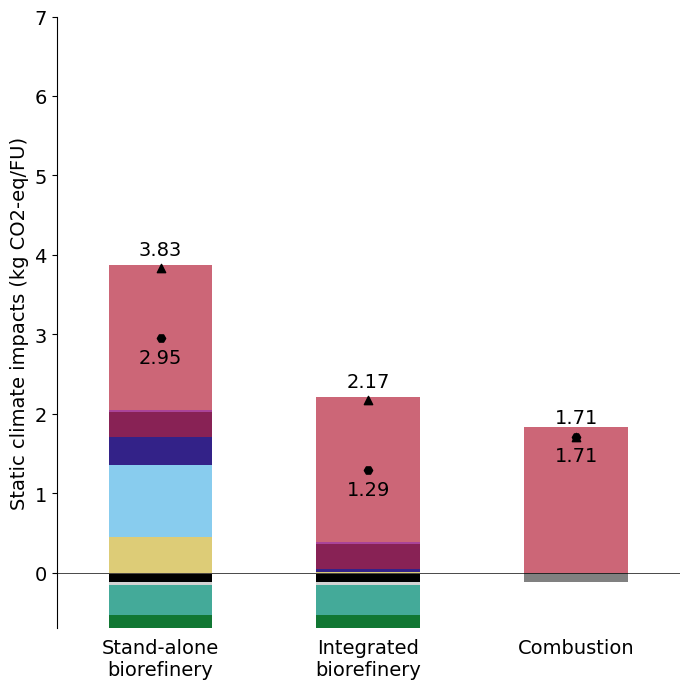

In [52]:
# GWP scores with substitution
GWP_scores_ei39 = list(total_df_vf.sum())
GWP_scores_ei39 = ['%.2f' % elem for elem in GWP_scores_ei39]
GWP_scores_ei39 = [float(elem) for elem in GWP_scores_ei39] # the list items must be floats
GWP_scores_ei39

# GWP scores without substitution
df_wo_subst_ei39 = total_df_vf.drop(['heat (burd.)', 'tall oil (sub.)', 'starch (sub.)', 'phenol (sub.)', 'pulp (sub.)'])
GWP_scores_wo_subst_ei39 = list(df_wo_subst_ei39.sum())
GWP_scores_wo_subst_ei39 = ['%.2f' % elem for elem in GWP_scores_wo_subst_ei39]
GWP_scores_wo_subst_ei39 = [float(elem) for elem in GWP_scores_wo_subst_ei39] # the list items must be floats
GWP_scores_wo_subst_ei39

# transpose the dataframe
df_transposed = total_df_vf.T

fig, ax = plt.subplots(figsize=(7, 7))

ax.set_ylim(-0.7,7.0)

col_names = ['Stand-alone\nbiorefinery', 'Integrated\nbiorefinery', 'Combustion']

bars = df_transposed.plot(kind='bar', stacked=True, ax=ax, color=colors,legend = False, width=0.5)
ax.set_ylabel('Static climate impacts (kg CO2-eq/FU)', fontsize=14)
#ax.legend(loc='lower center', bbox_to_anchor=(0.65, 0.7), title_fontsize='12', fontsize='14', ncol=2, frameon = False)

ax.tick_params(axis='x', labelsize=14, rotation=0)
ax.tick_params(axis='y', labelsize=14)
ax.tick_params(axis='x', which='both', bottom=False)  # Remove x-axis ticks

ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# add the single GWP100 scores for each scenario
categories_index = np.arange(len(col_names))
ax.scatter(categories_index, GWP_scores_wo_subst_ei39, color='black', marker = '^', zorder=5)
ax.scatter(categories_index, GWP_scores_ei39, color='black', marker = 'H', zorder=5)

for i, val in enumerate(GWP_scores_ei39):
    ax.text(categories_index[i], val - 0.12, f'{val}', ha='center', color='black',va = 'top', fontsize=14)

for i, val in enumerate(GWP_scores_wo_subst_ei39):
    ax.text(categories_index[i], val+0.12, f'{val}', ha='center', color='black',va = 'bottom', fontsize=14)

# +/- 0.08

plt.tight_layout()

#plt.savefig(str(result_dir+'/fig5_DCFs_results_' + ei + '.pdf'), dpi=300)
plt.savefig(str(result_dir+'/fig5_static_GWP100_results_'+ei+'.pdf'), dpi=300)

plt.show()

In [53]:
stop

NameError: name 'stop' is not defined

# 7. Calculate the impacts for other impact categories using ReCiPe

In [54]:
recipe_all = alg.findMethods('ReCiPe 2016 v1.03, midpoint (H)')
recipe = recipe_all[18:36] # remove all the "no LT" impact categories
recipe_noGWP = [ic for ic in recipe if 'climate change' not in ic]
len(recipe_noGWP)

17

In [55]:
df_bioref_standalone_allICs = alg.compute_impacts([lipophilic_extraction, 
                                            sugar_extraction_withlosses, 
                                            pulping_withlosses, 
                                            heat_burdens, 
                                            #processA, 
                                            #processB, 
                                            #processC, 
                                            heat_residues, 
                                            # EoL
                                            EoL_pulp_biomed,
                                            EoL_pulp_textile, 
                                            EoL_pulp_nanocomposite,
                                            EoL_phenol_auto, 
                                            EoL_phenol_construction, 
                                            EoL_phenol_furniture, 
                                            EoL_phenol_electronics, 
                                            EoL_phenol_others, 
                                            EoL_starch_cardboard, 
                                            EoL_talloil_biofuel,                                   
                                            # substitution
                                            talloil_sub,
                                            starch_sub,
                                            phenol_sub, 
                                            pulp_sub],
                                            # lcia method
                                            recipe_noGWP,
                                            # parameters
                                            standalone = 1,
                                            percentage_losses = 0,
                                            grid_loc = 'grid_SE',
                                            mw_loc = 'mw_RER'
                                          )
df_bioref_standalone_allICs.to_excel(str(result_dir+"/all_impacts_recipe_standalone_bioref_" + str(ei)+ ".xlsx"))

In [56]:
df_bioref_integrated_allICs = alg.compute_impacts([lipophilic_extraction, 
                                            sugar_extraction_withlosses, 
                                            pulping_withlosses, 
                                            heat_burdens, 
                                            #processA, 
                                            #processB, 
                                            #processC, 
                                            heat_residues, 
                                            # EoL
                                            EoL_pulp_biomed,
                                            EoL_pulp_textile, 
                                            EoL_pulp_nanocomposite,
                                            EoL_phenol_auto, 
                                            EoL_phenol_construction, 
                                            EoL_phenol_furniture, 
                                            EoL_phenol_electronics, 
                                            EoL_phenol_others, 
                                            EoL_starch_cardboard, 
                                            EoL_talloil_biofuel,                                   
                                            # substitution
                                            talloil_sub,
                                            starch_sub,
                                            phenol_sub, 
                                            pulp_sub],
                                            # lcia method
                                            recipe_noGWP,
                                            # parameters
                                            standalone = 0,
                                            percentage_losses = 0,
                                            grid_loc = 'grid_SE',
                                            mw_loc = 'mw_RER'
                                          )
df_bioref_integrated_allICs.to_excel(str(result_dir+"/all_impacts_recipe_integrated_bioref_" + str(ei)+ ".xlsx"))

In [57]:
df_combustion_allICs = alg.compute_impacts([heat_CHP_bark_scaled],
                            recipe_noGWP,
                            # parameters
                            percentage_losses = 0,
                            grid_loc = 'grid_SE',
                            mw_loc = 'mw_RER'
                            )
df_combustion_allICs.to_excel(str(result_dir+"/all_impacts_recipe_integrated_combustion_" + str(ei)+ ".xlsx"))

In [58]:
ic_dict = {
    'water consumption potential' : {'name': 'water use - water consumption potential (WCP)[cubic meter]',
                                                 'unit': 'm3-Eq',
                                                 'abbrev': 'WCP'},
    'freshwater ecotoxicity potential' : {'name': 'ecotoxicity: freshwater - freshwater ecotoxicity potential (FETP)[kg 1,4-DCB-Eq]',
                                                 'unit': 'kg 1,4-DCB-Eq',
                                                 'abbrev': 'FETP'},
    'particulate matter formation':  {'name': 'particulate matter formation - particulate matter formation potential (PMFP)[kg PM2.5-Eq]',
                                                 'unit': 'kg PM2.5-Eq',
                                                 'abbrev': 'PMFP'},
    'human toxicity potential, carcinogenics':  {'name': 'human toxicity: carcinogenic - human toxicity potential (HTPc)[kg 1,4-DCB-Eq]',
                                                 'unit': 'kg 1,4-DCB-Eq',
                                                 'abbrev': 'HTPc'},
    'surplus ore potential' : {'name': 'material resources: metals/minerals - surplus ore potential (SOP)[kg Cu-Eq]',
                                                 'unit': 'kg Cu-Eq',
                                                 'abbrev': 'SOP'},
    'ionising radiation potential' : {'name': 'ionising radiation - ionising radiation potential (IRP)[kg Co-60-Eq]',
                                                 'unit': 'kg Co-60-Eq',
                                                 'abbrev': 'IRP'}
    }

In [59]:
def plot_ic (ic_name,ax): 

    # get the data
    name = ic_dict[ic_name]['name']
    df_ic_col_bioref_standalone = pd.DataFrame({'Stand-alone biorefinery': df_bioref_standalone_allICs[name]})
    df_ic_col_bioref_integrated = pd.DataFrame({'Integrated biorefinery': df_bioref_integrated_allICs[name]})
    df_ic_col_combustion = pd.DataFrame({'Combustion': df_combustion_allICs[name]})
    merged_df_table = pd.concat([df_ic_col_bioref_standalone, df_ic_col_bioref_integrated, df_ic_col_combustion], axis = 1)

    # get the total scores
    total_scores = list(merged_df_table.sum())
    total_scores = ['%.4f' % elem for elem in total_scores]
    total_scores = [float(elem) for elem in total_scores] # the list items must be floats

    # aggregate the EoL values into a unique row
    total_df = merged_df_table.copy()
    total_df.loc['EoL']= total_df.iloc[5:15].sum()
    total_df_vf = total_df.drop(total_df.index[5:15])

    # move the EoL row up
    row_to_move = total_df_vf.iloc[[10]]
    total_df_vf = total_df_vf.drop(['EoL'])
    total_df_vf = pd.concat([total_df_vf.iloc[:5], row_to_move, total_df_vf.iloc[5:]])
    
    #change index labels
    index_labels = ['lipophilic extraction', 'sugar extraction', 'pulping', 'heat (burd.)', 'heat (RB)','EoL', 
                    'tall oil (sub.)', 'starch (sub.)', 'phenol (sub.)', 'pulp (sub.)', 'heat CHP bark']
    
    total_df_vf.index = index_labels
    total_df_vf.rename(columns={'Stand-alone biorefinery': 'Sta.', 'Integrated biorefinery': 'Int.', 'Combustion':'Comb.'}, inplace=True)

    # plot the graph
    ic_abbrev = ic_dict[ic_name]['abbrev']
    ic_unit = ic_dict[ic_name]['unit']
    
    df_transposed = total_df_vf.T
    
    bars = df_transposed.plot(kind='bar', stacked=True, ax=ax, color=colors, legend=False)
    ax.set_ylabel(str(ic_abbrev + ' (' +ic_unit+')'), fontsize=10)
    # ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), title_fontsize='10', fontsize='10', ncol=4)
    
    ax.tick_params(axis='x', labelsize=10, rotation=0)
    ax.tick_params(axis='y', labelsize=10)
    ax.tick_params(axis='x', which='both', bottom=False)  # Remove x-axis ticks
    
    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    
    # add the single GWP100 scores for each scenario
    categories_index = np.arange(len(new_names))
    ax.scatter(categories_index, total_scores, color='black', marker = 'H', zorder=5)

    import matplotlib.ticker as ticker
    formatter = ticker.ScalarFormatter(useMathText=True)
    formatter.set_powerlimits((-2, 2))
    ax.yaxis.set_major_formatter(formatter)
    ax.yaxis.get_offset_text().set_position((0.01, 1.02))
            
    
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))

    return by_label.values(), by_label.keys()

/tmp/ipykernel_43176/3285163598.py:34: UserWarning: Legend does not support handles for list instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/users/explain/axes/legend_guide.html#controlling-the-legend-entries
  leg = fig.legend(labels,handles, loc='lower center',bbox_to_anchor=(0.5, -0.15),ncols = 6,frameon = False)
/tmp/ipykernel_43176/3285163598.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_43176/3285163598.py:36: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


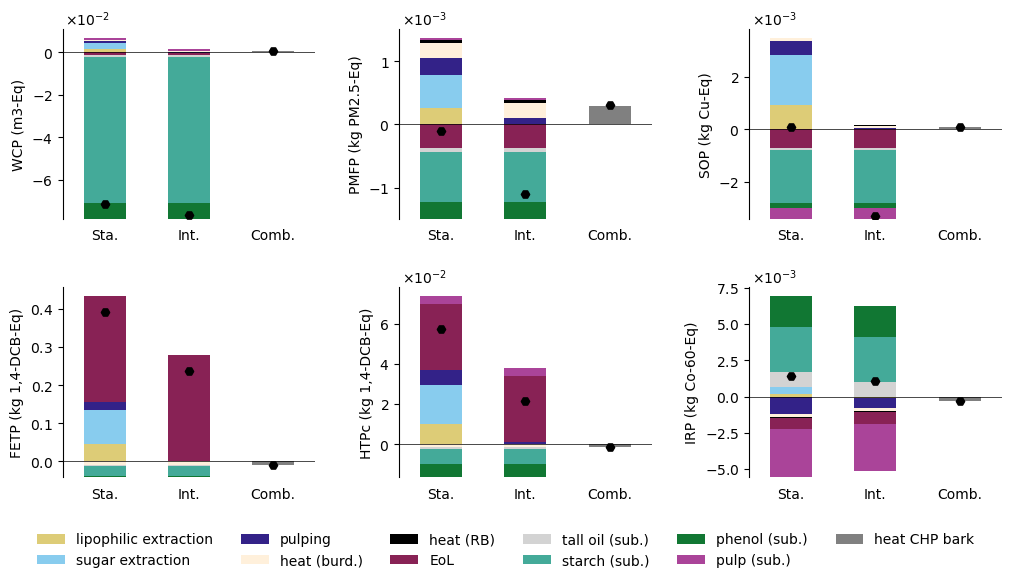

In [60]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

fig = plt.figure(constrained_layout=True,figsize = (10,5))

ncols = 3
nrows = len(ic_dict.keys()) // ncols
keys = list(ic_dict.keys())
new_names = ['Stand-alone\nbiorefinery', 'Integrated\nbiorefinery', 'Combustion']


spec = gridspec.GridSpec(ncols=ncols, nrows=nrows, figure=fig,hspace=0.1,wspace=0.1)

handles = []
labels = []

count = 0
for i in range(ncols):
    for j in range(nrows): # n

        ax = fig.add_subplot(spec[j, i])      

     
        plot_ic (keys[count],ax = ax)

        plt.draw()
        labels, handles = ax.get_legend_handles_labels()

        if count>0:
            handles.append(handles)
            labels.append(labels)

        count+=1
leg = fig.legend(labels,handles, loc='lower center',bbox_to_anchor=(0.5, -0.15),ncols = 6,frameon = False)

plt.tight_layout()

plt.savefig(str(result_dir+'/SM1_lcia_ICs_' + ei + '.pdf'), dpi=300,bbox_extra_artists=[leg,], bbox_inches='tight')

plt.show()

In [61]:
df_bioref_standalone_allICs.loc['Total'] = df_bioref_standalone_allICs.sum()
df_bioref_integrated_allICs.loc['Total'] = df_bioref_integrated_allICs.sum()
df_combustion_allICs.loc['Total'] = df_combustion_allICs.sum()

In [62]:
new_df = pd.DataFrame(columns=list(df_bioref_standalone_allICs.columns))
new_df.loc['Stand-alone\nbiorefinery']=df_bioref_standalone_allICs.loc['Total']
new_df.loc['Integrated\nbiorefinery']=df_bioref_integrated_allICs.loc['Total']
new_df.loc['Combustion']=df_combustion_allICs.loc['Total']
df_transp = new_df.T
df_transp.to_excel(str(result_dir+"/table3_all_impacts_recipe_" + str(ei)+ ".xlsx"))
df_transp

,Stand-alone\nbiorefinery,Integrated\nbiorefinery,Combustion
acidification: terrestrial - terrestrial acidification potential (TAP)[kg SO2-Eq],-0.00183072,-0.0043722,0.00102449
"ecotoxicity: freshwater - freshwater ecotoxicity potential (FETP)[kg 1,4-DCB-Eq]",0.392271,0.237679,-0.0106867
"ecotoxicity: marine - marine ecotoxicity potential (METP)[kg 1,4-DCB-Eq]",0.518376,0.327409,-0.0119362
"ecotoxicity: terrestrial - terrestrial ecotoxicity potential (TETP)[kg 1,4-DCB-Eq]",3.47673,-4.47458,0.73497
"energy resources: non-renewable, fossil - fossil fuel potential (FFP)[kg oil-Eq]",0.210413,-0.427146,-0.053681
eutrophication: freshwater - freshwater eutrophication potential (FEP)[kg P-Eq],-0.000179391,-0.000314542,-1.07907e-06
eutrophication: marine - marine eutrophication potential (MEP)[kg N-Eq],-0.000506494,-0.000523093,-5.88898e-07
"human toxicity: carcinogenic - human toxicity potential (HTPc)[kg 1,4-DCB-Eq]",0.0571943,0.0213239,-0.00153886
"human toxicity: non-carcinogenic - human toxicity potential (HTPnc)[kg 1,4-DCB-Eq]",6.07015,4.9288,0.304944
ionising radiation - ionising radiation potential (IRP)[kg Co-60-Eq],0.00137013,0.00111019,-0.000280694


# 8. Sensitivity analysis

### Influence of the geographical location

The change of geographical location influences the indirect emissions from the biorefinery and combustion scneario only. In this model, the direct emissions remain similar, no matter the geographical location. The percentage of losses is fixed to 0.

In [63]:
bioref_model = alg.newActivity(db_name = USER_DB,
                               name = 'bioref_model',
                               unit = 'unit',
                               exchanges={lipophilic_extraction:1, 
                                            sugar_extraction_withlosses:1, 
                                            pulping_withlosses:1, 
                                            heat_burdens:1, 
                                            #processA, 
                                            #processB, 
                                            #processC, 
                                            heat_residues:1, 
                                            # EoL
                                            EoL_pulp_biomed:1,
                                            EoL_pulp_textile:1, 
                                            EoL_pulp_nanocomposite:1,
                                            EoL_phenol_auto:1, 
                                            EoL_phenol_construction:1, 
                                            EoL_phenol_furniture:1, 
                                            EoL_phenol_electronics:1, 
                                            EoL_phenol_others:1, 
                                            EoL_starch_cardboard:1, 
                                            EoL_talloil_biofuel:1,                                   
                                            # substitution
                                            talloil_sub:1,
                                            starch_sub:1,
                                            phenol_sub:1, 
                                            pulp_sub:1})

In [64]:
df_bioref_standalone_geoloc = alg.compute_impacts([bioref_model],
                                                  # lcia method
                                                  [ipcc2021],
                                                    # parameters
                                                    standalone = 1,
                                                    percentage_losses = 0,
                                                    grid_loc = ['grid_SE','grid_SE','grid_NO','grid_FI','grid_DK','grid_FR','grid_DE','grid_BE','grid_LU','grid_NL','grid_AT','grid_RER'],
                                                    mw_loc = ['mw_RER','mw_SE','mw_NO','mw_FI','mw_DK','mw_FR','mw_DE','mw_BE','mw_LU','mw_NL','mw_AT','mw_RER']
                                                  )

df_bioref_integrated_geoloc = alg.compute_impacts([bioref_model],
                                                  # lcia method
                                                  [ipcc2021],
                                                    # parameters
                                                    standalone = 0,
                                                    percentage_losses = 0,
                                                    grid_loc = ['grid_SE','grid_SE','grid_NO','grid_FI','grid_DK','grid_FR','grid_DE','grid_BE','grid_LU','grid_NL','grid_AT','grid_RER'],
                                                    mw_loc = ['mw_RER','mw_SE','mw_NO','mw_FI','mw_DK','mw_FR','mw_DE','mw_BE','mw_LU','mw_NL','mw_AT','mw_RER']
                                                  )

df_combustion_geoloc = alg.compute_impacts([heat_CHP_bark_scaled],
                            [ipcc2021],
                            # parameters
                            percentage_losses = 0,
                            grid_loc = ['grid_SE','grid_SE','grid_NO','grid_FI','grid_DK','grid_FR','grid_DE','grid_BE','grid_LU','grid_NL','grid_AT','grid_RER'],
                            mw_loc = ['mw_RER','mw_SE','mw_NO','mw_FI','mw_DK','mw_FR','mw_DE','mw_BE','mw_LU','mw_NL','mw_AT','mw_RER']
                            )

[INFO] Db changed recently, clearing cache expr
[INFO] Db changed recently, clearing cache lcia


In [67]:
# merge the three dataframes
merged_df_geoloc = pd.concat([df_bioref_standalone_geoloc, df_bioref_integrated_geoloc, df_combustion_geoloc], axis = 1)
# change the name of the columns
merged_df_geoloc.columns = ['Stand-alone biorefinery', 'Integrated biorefinery', 'Combustion']
merged_df_geoloc.index = ['Base.', 'SE', 'NO', 'FI', 'DK', 'FR', 'DE', 'BE', 'LU', 'NL', 'AT', 'RER']
# add the GWP100 for direct CO2 emissions (same for all scenarios) 
merged_df_geoloc+=1.83
merged_df_geoloc

,Stand-alone biorefinery,Integrated biorefinery,Combustion
Base.,2.94701,1.28626,1.70891
SE,2.63251,0.971762,1.70889
NO,1.54934,1.21348,1.83201
FI,3.10612,0.93255,1.66124
DK,1.55883,1.132,1.82355
FR,1.72837,1.30859,1.82422
DE,2.32705,1.01364,1.74116
BE,3.31184,0.883202,1.63753
LU,4.11358,1.11471,1.58457
NL,1.93433,1.10051,1.78573


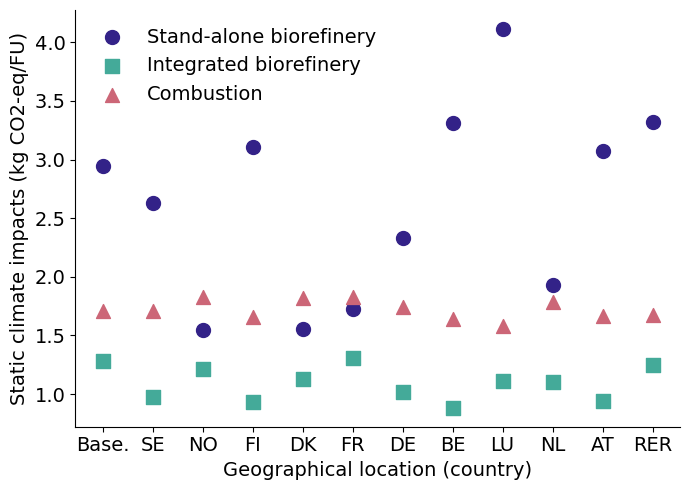

In [68]:
# Plotting the data
fig, ax = plt.subplots(figsize=(7, 5))

plt.scatter(merged_df_geoloc.index, merged_df_geoloc['Stand-alone biorefinery'], label='Stand-alone biorefinery', marker='o', color = '#332288', s=100)
plt.scatter(merged_df_geoloc.index, merged_df_geoloc['Integrated biorefinery'], label='Integrated biorefinery', marker='s', color = '#44AA99', s=100)
plt.scatter(merged_df_geoloc.index, merged_df_geoloc['Combustion'], label='Combustion', marker='^', color = '#CC6677', s=100)

# Adding titles and labels
plt.xlabel('Geographical location (country)', size =14)
plt.ylabel('Static climate impacts (kg CO2-eq/FU)', size=14)
plt.legend(frameon=False, fontsize=14)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.tick_params(axis='x', labelsize=14, rotation=0)
ax.tick_params(axis='y', labelsize=14)

    
plt.tight_layout()
plt.savefig(str(result_dir+'/fig6_sensitivity_geoloc_GWP100'+ei+'.pdf'), dpi=300)


# Show plot
plt.show()

## 7.2. Influence of the background data

The choice of the background database influences the calculation of the indirect emissions. To perform this sensitivity analysis, the code above needs to be run until the end of Section 8.3, for each of the background databases. The results obtained are stored in Excel files that are imported below to plot the sensisitvity analysis graph. 

In [70]:
# import the data from the Excel files
df_ei39 = pd.read_excel(str(result_dir+'/total_climate_impacts_IPCC_ecoinvent_3.9_conseq.xlsx'))
df_ei39_REMIND_SSP2_Base = pd.read_excel(str(result_dir+'/total_climate_impacts_IPCC_ecoinvent_consequential_3.9_remind_SSP2-Base_2045.xlsx'))
df_ei39_REMIND_SSP2_PkBudg500 = pd.read_excel(str(result_dir+'/total_climate_impacts_IPCC_ecoinvent_consequential_3.9_remind_SSP2-PkBudg500_2045.xlsx'))
df_ei39_REMIND_SSP1_PkBudg500 = pd.read_excel(str(result_dir+'/total_climate_impacts_IPCC_ecoinvent_consequential_3.9_remind_SSP1-PkBudg500_2045.xlsx'))
df_ei39_IMAGE_SSP2_Base = pd.read_excel(str(result_dir+'/total_climate_impacts_IPCC_ecoinvent_consequential_3.9_image_SSP2-Base_2045.xlsx'))

df_list = [df_ei39, df_ei39_REMIND_SSP2_PkBudg500, df_ei39_REMIND_SSP1_PkBudg500, df_ei39_REMIND_SSP2_Base, df_ei39_IMAGE_SSP2_Base]
db_names = ['Conventional', 'REMIND-SSP2-PkBudg500-2045', 'REMIND-SSP1-PkBudg500-2045', 'REMIND-SSP2-Base-2045','IMAGE-SSP2-Base-2045']

df_total_climate_impacts = pd.DataFrame(columns=['Stand-alone\nbiorefinery','Integrated\nbiorefinery','Combustion'])

for i in range(len(df_list)):
    df = df_list[i]
    # reset the index
    df = df.set_index('Unnamed: 0')
    # calculate the total value
    df.loc['Total'] = df.sum()
    # add the total into the new dataframe
    df_total_climate_impacts.loc[db_names[i]] = df.loc['Total'] 

df_total_climate_impacts

,Stand-alone\nbiorefinery,Integrated\nbiorefinery,Combustion
Conventional,2.94808,1.28733,1.71006
REMIND-SSP2-PkBudg500-2045,1.80381,1.45917,1.83301
REMIND-SSP1-PkBudg500-2045,1.77792,1.46248,1.83601
REMIND-SSP2-Base-2045,1.70433,1.3288,1.83109
IMAGE-SSP2-Base-2045,5.62983,1.01208,1.43051


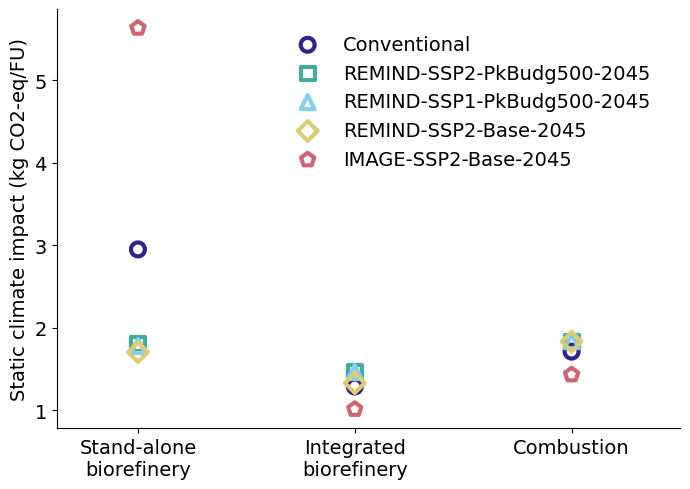

In [71]:
# Marker styles and colors for different models
markers = ['o', 's', '^', 'D', 'p']
colors = ['#332288', '#44AA99', '#88CCEE', '#DDCC77', '#CC6677']
scenarios= ['Stand-alone\nbiorefinery','Integrated\nbiorefinery','Combustion']

# Create figure and axis
fig, ax = plt.subplots(figsize=(7,5))

# Set the positions of the x-ticks with reduced spacing
x_positions = (np.arange(len(scenarios))*4)  # Reduced spacing

# Plotting data points for each model in all scenarios
for j, db in enumerate(db_names):
    x_coords = []
    y_coords = []
    for i, scenario in enumerate(scenarios):
        x_coords.append(x_positions[i])  # Adjusted x-axis position
        y_coords.append(df_total_climate_impacts[scenario][db])  # Corresponding y-value for the model

    # Plot each model with a unique marker and color
    plt.scatter(x_coords, y_coords, marker=markers[j], facecolor = 'None',edgecolor=colors[j], s=100, label=db, linewidths=3)
    #plt.scatter(x_coords, y_coords, marker=markers[j], color=colors[j], s=100, label=model)

# Set labels and title#
plt.xticks(ticks=x_positions, labels=scenarios, size=14)
ax.set_xlim(-1.5,10)
#plt.xlabel("Scenarios")
plt.ylabel("Static climate impact (kg CO2-eq/FU)", size = 14)
#plt.title("Scatter Plot of Different Scenarios and Models")

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.tick_params(axis='x', labelsize=14, rotation=0)
ax.tick_params(axis='y', labelsize=14)

# Add legend for models, with a smaller font size and adjusted position
plt.legend(frameon=False,bbox_to_anchor=(0.98, 0.98), loc='upper right', fontsize=14)

# Show grid
#plt.grid(True)

# Adjust layout to make room for the legend
plt.tight_layout()
plt.savefig(str(result_dir+'/fig6_sensitivity_background_'+ei+'.pdf'), dpi=300)

# Show the plot
plt.show()